In [4]:
import matplotlib.pyplot as plt
import json
import torch
import pickle
from typing import Optional
from matplotlib.colors import Normalize
import numpy as np
import os

import experiments.utils as utils



ae_sweep_paths = {"pythia70m_test_sae": {"resid_post_layer_3": {"trainer_ids": [0]}}}

dictionaries_path = "../dictionary_learning/dictionaries"

sweep_name = "pythia70m_test_sae"
submodule_trainers = {"resid_post_layer_3": {"trainer_ids": [0]}}

ae_group_paths = utils.get_ae_group_paths(
    dictionaries_path, sweep_name, submodule_trainers
)
ae_paths = utils.get_ae_paths(ae_group_paths)

include_diff = True

print(ae_paths)

['../dictionary_learning/dictionaries/pythia70m_test_sae/resid_post_layer_3/trainer_0/']


In [5]:
results = {}
threshold = 5

# There's a potential issue as we currently assume that all SAEs have the same classes.


def get_classes(first_path: str) -> list[int]:
    class_accuracies_file = f"{first_path}/class_accuracies.pkl"
    with open(class_accuracies_file, "rb") as f:
        class_accuracies = pickle.load(f)
    return list(class_accuracies[-1].keys())


for ae_path in ae_paths:

    eval_results_file = f"{ae_path}/eval_results.json"

    if not os.path.exists(eval_results_file):
        print(f"Warning: {eval_results_file} does not exist.")
        continue

    with open(eval_results_file, "r") as f:
        eval_results = json.load(f)

    l0 = eval_results["l0"]
    frac_recovered = eval_results["frac_recovered"]

    results[ae_path] = {
        "l0": l0,
        "frac_recovered": frac_recovered,
    }

    config_file = f"{ae_path}/config.json"

    with open(config_file, "r") as f:
        config = json.load(f)

    results[ae_path]["l1_penalty"] = config["trainer"]["l1_penalty"]
    results[ae_path]["lr"] = config["trainer"]["lr"]
    results[ae_path]["dict_size"] = config["trainer"]["dict_size"]

    if not include_diff:
        continue

    intended_diffs = []
    unintended_diffs = []

    class_accuracies_file = f"{ae_path}/class_accuracies.pkl"

    if not os.path.exists(class_accuracies_file):
        print(f"Warning: {class_accuracies_file} does not exist. Removing this path from results.")
        del results[ae_path]
        continue

    with open(class_accuracies_file, "rb") as f:
        class_accuracies = pickle.load(f)

    classes = list(class_accuracies[-1].keys())

    for class_id in classes:
        clean = class_accuracies[-1][class_id]
        patched = class_accuracies[class_id][threshold][class_id]

        diff = clean - patched
        intended_diffs.append(diff)

    for intended_class_id in classes:
        for unintended_class_id in classes:
            if intended_class_id == unintended_class_id:
                continue

            clean = class_accuracies[-1][unintended_class_id]
            patched = class_accuracies[intended_class_id][threshold][unintended_class_id]
            diff = clean - patched
            unintended_diffs.append(diff)

    average_intended_diff = sum(intended_diffs) / len(intended_diffs)
    average_unintended_diff = sum(unintended_diffs) / len(unintended_diffs)
    average_diff = average_intended_diff - average_unintended_diff

    results[ae_path]["average_diff"] = average_diff
    results[ae_path]["average_intended_diff"] = average_intended_diff
    results[ae_path]["average_unintended_diff"] = average_unintended_diff


    # Use these to analyze hyperparameters vs L0 / frac recovered
    # results[ae_path]["average_diff"] = results[ae_path]["l1_penalty"]
    # results[ae_path]["average_diff"] = results[ae_path]["lr"]  
    # results[ae_path]["average_diff"] = results[ae_path]["dict_size"]

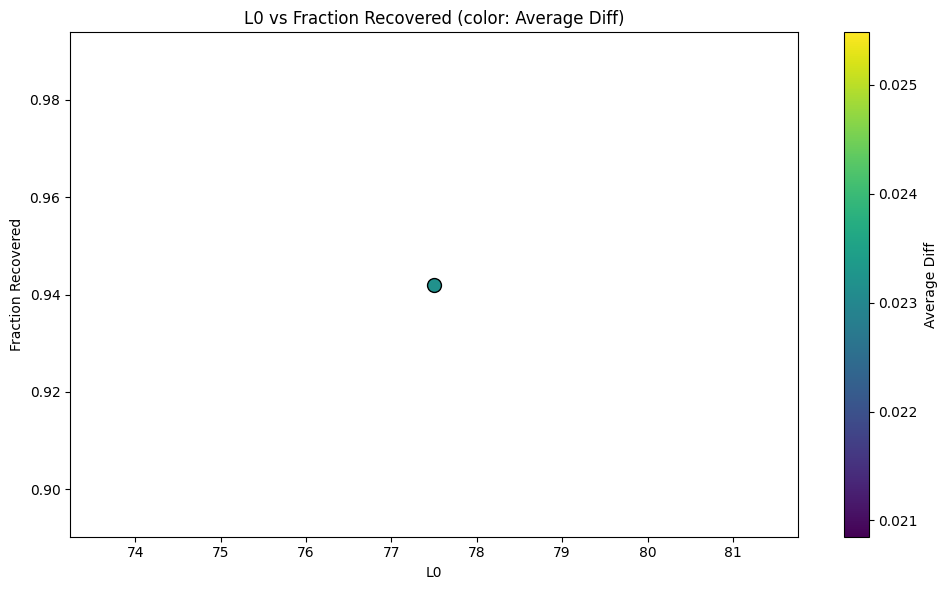

In [6]:
def plot_3var_graph(
    results: dict,
    xlims: Optional[tuple[float, float]] = None,
    y_lims: Optional[tuple[float, float]] = None,
    colorbar_label: str = "Average Diff",
    output_filename: Optional[str] = None,
):
    # Extract data from results
    l0_values = [data['l0'] for data in results.values()]
    frac_recovered_values = [data['frac_recovered'] for data in results.values()]
    average_diff_values = [data['average_diff'] for data in results.values()]

    # Create the scatter plot
    fig, ax = plt.subplots(figsize=(10, 6))

    # Create a normalize object for color scaling
    norm = Normalize(vmin=min(average_diff_values), vmax=max(average_diff_values))

    # Plot data points
    scatter = ax.scatter(
        l0_values,
        frac_recovered_values,
        c=average_diff_values,
        cmap="viridis",
        s=100,
        norm=norm,
        edgecolor="black"
    )

    # Add colorbar
    cbar = fig.colorbar(scatter, ax=ax, label=colorbar_label)

    # Set labels and title
    ax.set_xlabel("L0")
    ax.set_ylabel("Fraction Recovered")
    ax.set_title("L0 vs Fraction Recovered (color: Average Diff)")

    # Set axis limits
    if xlims:
        ax.set_xlim(*xlims)
    if y_lims:
        ax.set_ylim(*y_lims)

    plt.tight_layout()

    # Save and show the plot
    if output_filename:
        plt.savefig(output_filename, bbox_inches="tight")
    plt.show()

# print(results)
if include_diff:
    plot_3var_graph(results)


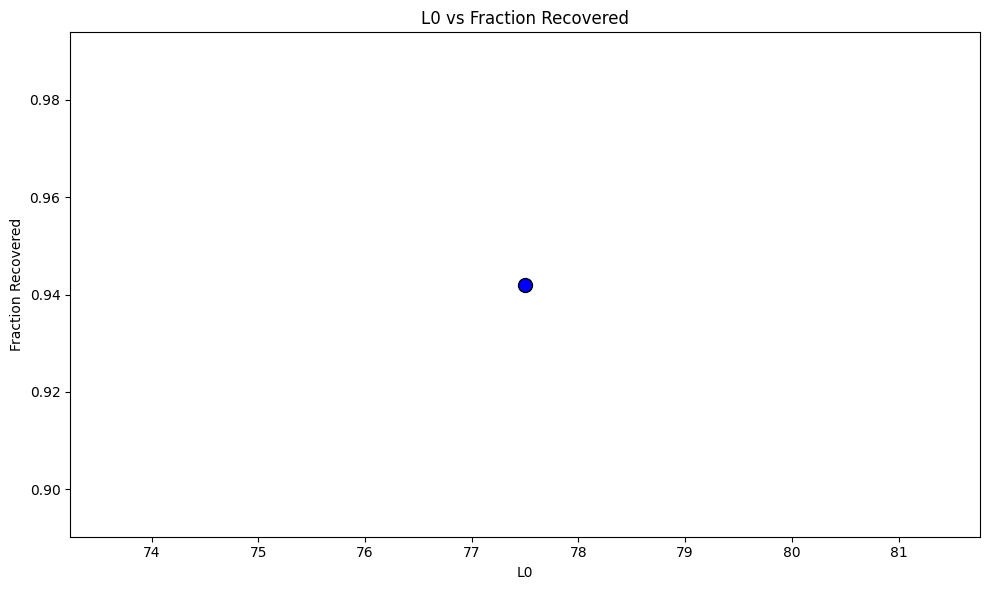

In [7]:
def plot_2var_graph(
    results: dict,
    xlims: Optional[tuple[float, float]] = None,
    y_lims: Optional[tuple[float, float]] = None,
    output_filename: Optional[str] = None,
):
    # Extract data from results
    l0_values = [data['l0'] for data in results.values()]
    frac_recovered_values = [data['frac_recovered'] for data in results.values()]

    # Create the scatter plot
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot data points
    ax.scatter(
        l0_values,
        frac_recovered_values,
        s=100,
        edgecolor="black",
        c="blue"  # You can change this color as needed
    )

    # Set labels and title
    ax.set_xlabel("L0")
    ax.set_ylabel("Fraction Recovered")
    ax.set_title("L0 vs Fraction Recovered")

    # Set axis limits
    if xlims:
        ax.set_xlim(*xlims)
    if y_lims:
        ax.set_ylim(*y_lims)

    plt.tight_layout()

    # Save and show the plot
    if output_filename:
        plt.savefig(output_filename, bbox_inches="tight")
    plt.show()

# Example usage:
plot_2var_graph(results)